## 🚀 Python Lab: ANN with Dropout (PyTorch Version)
> [Principles of ML course](https://github.com/mnarimani/PML_Spring2025_SUT) - Spring 2025 - Sharif <br>
> Lab sessions - Session 9 - May 25, 2025 <br>
> Author: M Narimani <br>

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mnarimani/PML_Spring2025_SUT/blob/main/Week09/01_ANN_Dropout_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mnarimani/PML_Spring2025_SUT/blob/main/Week09/01_ANN_Dropout_Torch.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## 🛠️ Setup: Importing Libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [5]:
# Check for GPU
device = torch.device("cuda" if cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"GPU name: {cuda.get_device_name(0) if cuda.is_available() else 'No GPU'}")
print(f"Num GPUs Available: {cuda.device_count()}")

Using device: cpu


## 1️⃣ Load Data

In [7]:
df = pd.read_csv('housepricedata.csv')
df.head()

,LotArea,OverallQual,OverallCond,TotalBsmtSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,AboveMedianPrice
0,8450,7,5,856,2,1,3,8,0,548,1
1,9600,6,8,1262,2,0,3,6,1,460,1
2,11250,7,5,920,2,1,3,6,1,608,1
3,9550,7,5,756,1,0,3,7,1,642,0
4,14260,8,5,1145,2,1,4,9,1,836,1


In [8]:
dataset = df.values
X = dataset[:,0:10]
y = dataset[:,10]

In [9]:
# Normalize features
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [10]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scale, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# Split data
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=42)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## 2️⃣ Model#1 (Baseline)

In [12]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

model = Model1()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [13]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in tqdm(range(epochs), desc="Training Epochs"): #for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs >= 0.5).float()
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
    return {'loss': train_losses, 'val_loss': val_losses, 'accuracy': train_accuracies, 'val_accuracy': val_accuracies}

# Train Model 1
hist = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.80it/s]


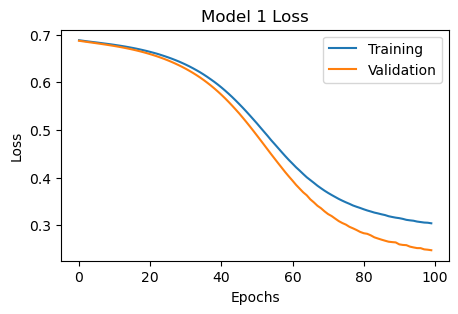

In [14]:
# Plot loss
plt.figure(figsize=(5, 3))
plt.plot(hist['loss'], label='Training')
plt.plot(hist['val_loss'], label='Validation')
plt.title('Model 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('01_ANN_Model1_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

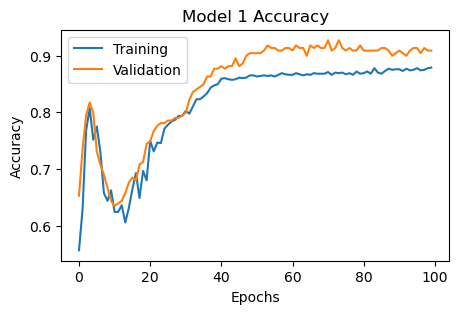

In [15]:
# Plot accuracy
plt.figure(figsize=(5, 3))
plt.plot(hist['accuracy'], label='Training')
plt.plot(hist['val_accuracy'], label='Validation')
plt.title('Model 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('01_ANN_Model1_acc.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 3️⃣ Model#2

In [17]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

model_2 = Model2()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

In [18]:
# Train Model 2
hist2 = train_model(model_2, train_loader, val_loader, criterion, optimizer, epochs=100)

Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [06:28<00:00,  3.88s/it]


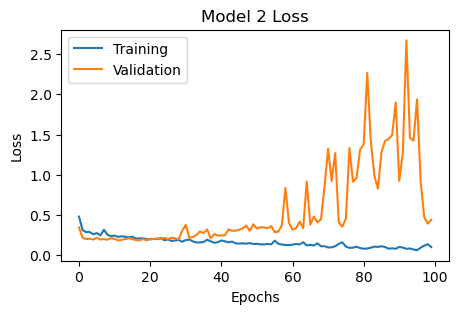

In [19]:
# Plot loss
plt.figure(figsize=(5, 3))
plt.plot(hist2['loss'], label='Training')
plt.plot(hist2['val_loss'], label='Validation')
plt.title('Model 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('01_ANN_Model2_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

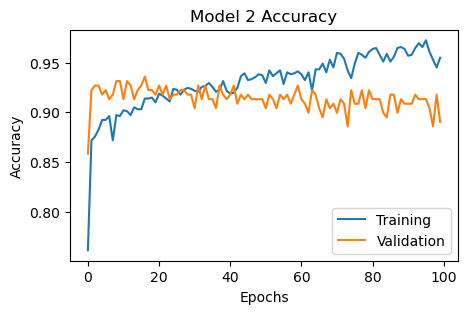

In [20]:
# Plot accuracy
plt.figure(figsize=(5, 3))
plt.plot(hist2['accuracy'], label='Training')
plt.plot(hist2['val_accuracy'], label='Validation')
plt.title('Model 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('01_ANN_Model2_acc.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 4️⃣ Model#3: Dropout

In [22]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

model_3 = Model3()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.001)

In [23]:
# Train Model 3
hist3 = train_model(model_3, train_loader, val_loader, criterion, optimizer, epochs=100)

Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [06:50<00:00,  4.11s/it]


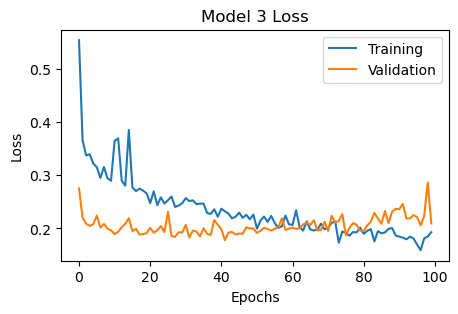

In [24]:
# Plot loss
plt.figure(figsize=(5, 3))
plt.plot(hist3['loss'], label='Training')
plt.plot(hist3['val_loss'], label='Validation')
plt.title('Model 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('01_ANN_Model3_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

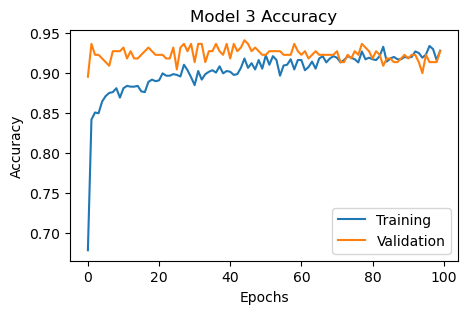

In [25]:
# Plot accuracy
plt.figure(figsize=(5, 3))
plt.plot(hist3['accuracy'], label='Training')
plt.plot(hist3['val_accuracy'], label='Validation')
plt.title('Model 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('01_ANN_Model3_acc.pdf', format='pdf', bbox_inches='tight')
plt.show()